In [1]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
################################################################

# From Butler, O'Dwyer (2018)

In [2]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to not truncate/split up any output

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=7)

np.random.seed(999)

# O'Dwyer Approach

In [3]:
## Asymmetric P matrix ##

def asymP(sig, n):

    return abs(normal(0, sig, (n, n))) ### "doubling-up" prob density by taking abs(normally distributed)???
                                        ### another distribution, but on the positive reals?
    

In [4]:
## Symmetric P matrix ##
def symP(sig, n):
    
    P = np.empty((n, n))
    for i in range(n):
        for j in range(i + 1):
            P[j][i] = P[i][j] = abs(normal(0, sig))
    
    return P

In [5]:
### Vectorized Asymmetric P matrix
def asymPvec(sig, n, k=1):
    return abs(normal(0, sig, (k, n, n))) # again, a half-normal with mean=1

In [6]:
### Vectorized Symmetric P matrix
def symPvec(sig, n, k=1): # k, number of matrices to generate
    P = abs(normal(0,sig,(k,n,n)))
    P = np.maximum(P,np.transpose(P,(0,2,1))) #transpose each sub-P (only transpose last two dimensions)
    ### Is max an issue? Favors less probable p-values, I guess. Not QUITE normally dist'd 
                            ### after abs and this maximum. Effectively increases sigma?
    
    return P

In [7]:
def symPvec2(sig,n,k=1): ### This way does not use max, but slightly slower than symPvec
    P = abs(normal(0,sig,(k,n,n)))
    inds = np.tril_indices(n, k=-1)
    P[:,inds[1],inds[0]] = P[:,inds[0],inds[1]]
    
    return P

## Calculating Eigenvalues for Single Fixed P

In [8]:
### Original O'Dwyer method for determining/plotting stability
   # Fix a symmetric P, sP, and an asymmetric P, aP.
    # Pick uniform-random equilibria r and s, where unif bounds are chosen to guarantee positive mu and rho
        #mu and rho are only implicit in r and s, could be calculated from Eq 6? in Appendix
     # Evaluate Jacobian at r and s at each P, append eigenvalues
    
sev = np.array([]) # append eigvals of symmetric P systems here
aev = np.array([]) 

## Parameters ##

n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
### SEE Methods in O'Dwyer for mu and rho

I = np.identity(n)

## Consumption Matrix ##
C = c * I

## Production matrices ##
sP = symP(sig, n)
aP = asymP(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vectors
                                                #produces this equilibrium

LD = np.zeros((n, n))
for k in range(5000): ### originally 5000
    ## Abundances ##    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    # O'Dwyer system Jacobian can be partitioned as follows:
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I ###
    LC = eps * c * s * I
    # LD fixed for all k

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states?

In [8]:
# Below, figuring the derivation of 'rlb'
# default PDF of normal, p_norm(x)
# sub for mu=0, sigma=1
# double due to half normal

$$ p_{norm}(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2} $$

$$ p_{norm}(x) = \frac{1}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \frac{2}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \sqrt{\frac{2}{\pi}}e^{-\frac{1}{2} x^2} $$

In [9]:
# expectation of the above is np.sqrt(2/np.pi)

$$ rlb = \frac{n  \sigma  \sqrt{\frac{2}{\pi}} } {c  \epsilon} $$

$$ rlb = \frac{20  \sqrt{\frac{2}{\pi}} } {0.25}$$

$$ rlb = 80  \sqrt{\frac{2}{\pi}} $$

In [10]:
# how get to rlb from expectation of halfnorm?

80*np.sqrt(2/np.pi)

63.83076486422923

## Plot eigenvalue parts, frequency

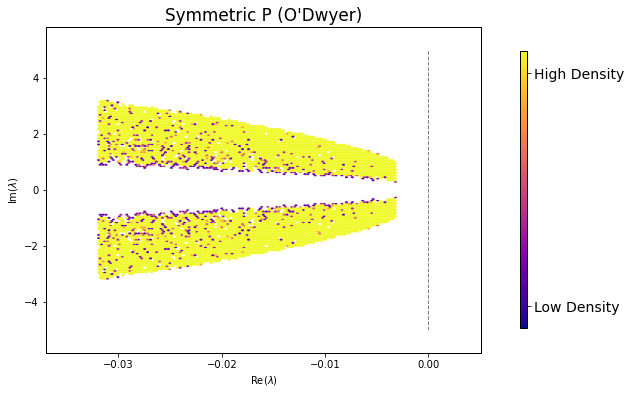

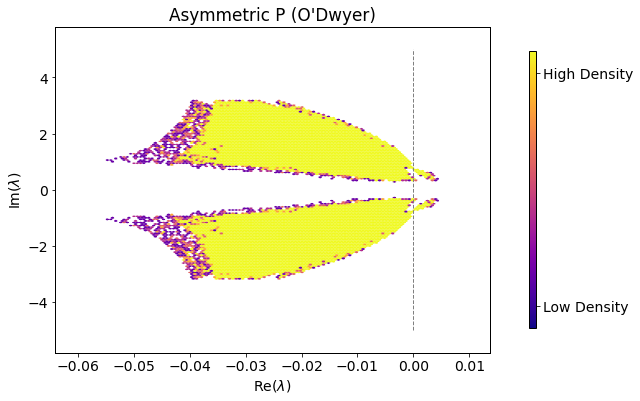

In [9]:
## Plot eigenvalues of linearized O'Dwyer system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (10, 6))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white') 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 14}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)
        plt.title('Symmetric P (O\'Dwyer)')
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        plt.title('Asymmetric P (O\'Dwyer)')

        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

## Frequency of stable n-size systems

In [10]:
### Original O'Dwyer method for determining/plotting stability
   # Do same as before but with k = 100 trials
    # Motivation: Hexbin plots do not indicate the number of stable systems (could be multiple positive real part eigvals in one matrix).
    
    # I HAVE NOT yet bothered vectorizing the random 'r' and 's', but I could do that if it turns out
         # to do anything in the regular for loop version (also pending O'Dwyer email response)
    # Loop over various system sizes, n. For each size, the eigvals of k_test systems.
    # Record fraction of total systems that are stable (for each system size, n)
    
k_test = 100
ns_test = list(range(1,61))
percents_stable_Odw = []

## Parameters ##
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

for nn in ns_test:
    
    aev = np.array([]) # just make new eigval array for each n, easier to just reshape after appending
                            # all eigvals for one system size (n) and append the stability_percent, then repeat

    
    ### SEE METHODS FOR mu AND rho

    I = np.identity(nn)

    ## Consumption Matrix ##

    C = c * I

    ## Production matrices ##
    sP = symP(sig, nn)
    aP = asymP(sig, nn)
    #sPvec = symPvec(sig, n)

    rlb = nn * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                    #produces this equilibrium

    LD = np.zeros((nn, nn))

    for k in range(k_test): ### originally 5000
        ## Abundances ##

        r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
        s = uniform(rlb / 10**4, rlb / 1000)

        ## Linearized System ##
           ### Jacobian, L, eval'd at steady state
        #     [ LA | aLB]
        #aL = [---------]
        #     [ LC | LD ]
        LA  = -c * s * I

        aLB = aP - c * r * I

        LC = eps * c * s * I
        LD = np.zeros((nn, nn))

        aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))

        ## Eigenvalues of Linearized System ##

        aev = np.append(aev, eigvals(aL))
    
    aev = aev.reshape(k_test,2*nn)
    pos_real_cts = np.sum(aev>0,1)
    
    percents_stable_Odw.append(len(pos_real_cts[pos_real_cts==0])/k_test)
        

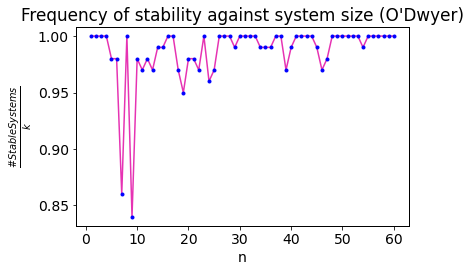

In [12]:
y_data = np.array(percents_stable_Odw)
x_data = np.array(ns_test)

# I forgot how to suppress matplotlib output automatically
plt.plot(x_data,y_data, color=(0.9,0.2,0.7));
plt.plot(x_data,y_data, 'b.');
plt.title('Frequency of stability against system size (O\'Dwyer)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
# looks like logistic growth (decay, really)
plt.show();


# When using AN EVEN HIGHER SAMPLE SIZE (k=1000 vs. k=100 down below), still very chaotic-looking
    # but with dip near n=[8,12]. Hrm...
    # Also, very stable.

In [13]:
x_data[np.argmin(y_data)] # Least chance of having stable system at this n, probably not an

9

# 'Random P and Corresponding Equilibria' Approach

In [15]:
#################################################################################################
### Instead, consider randomizing the (n,n) P(roduction matrix) and evaluating its Jacobian only at 
    ### the corresponding steady state.
# Choose k = 5000
# make (k,n,n) array (5000 P matrices)
# make (k,n,1) array (5000 R_stars)
# ""                 (5000 S_stars)
#################################################################################################

## Setup for new approach

In [14]:
def extract_block_diags(A,block_size):
    '''
    A, square matrix whose (square) block diagonals of shape (block_size,block_size) are to be extracted
    
    Needed for S_star_gen().
    
    Make sure block_size fits the matrix.
    '''
    block_diags = np.lib.stride_tricks.sliding_window_view(A,(block_size,block_size))[::block_size,::block_size]
    num_blocks = int(A.shape[0]/block_size)
    block_inds = list(range(num_blocks))
    
    return block_diags[block_inds,block_inds,:,:]

In [17]:
### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, the formulae below will produce feasible Steady States

### Resource-Competition Steady State vectors (R_star and S_star)

$\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$)

In [65]:
# Why are r_i values as big as 100??? Any way to normalize/nondimensionalize the model?

def R_star_gen(C,P,eps,mu): # P is actually 3-dimensional matrix (k nxn sub-P-matrices)
    '''
    Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
    that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
    No argument for number of sub-R_stars because that is inferred from 0th dimension of 'P' argument.
    '''
    k = P.shape[0]
    n = P.shape[-1]
    # mu = np.tile(mu,(k,1,1))
    
    A = np.linalg.inv(C.T)*(1/eps) # A is just (k,n,n)
    v = np.sum(np.transpose(P,(0,2,1)), 2).reshape(k,n,1) + mu #take row sums of P transpose, reshape to add 
    
    R_star = np.tensordot(A,v,axes=([1],[1]))
    R_star = R_star.reshape(n,k).T.reshape(k,n,1)
    return R_star

$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$

In [42]:
 ### OLD ###
# def S_star_gen(C,P,R_star,rho):
#     k = P.shape[0]
#     n = P.shape[1]
    
#     # How get (k,n,n) array of R_diags, where each of the k (n,n)'s is a diagonal array with the k-th R_star as its entries?
#     # fill main diagonal with flattened R_stars (it will be k*n x k*n), then extract the k (n,n) block main diagonal matrices
        
#     R_diag = np.zeros((k*n,k*n))
#     np.fill_diagonal(R_diag, R_star.reshape(k*n,))
#     ## now, R_diag is big array
#     R_diag = extract_block_diags(R_diag, n) # get each R_diag in (k,n,n)-shaped array
        
#     ### FIX THIS LATER FOR NON-IDENTITY C ################################
#     #  RC = np.dot(R_diag, C) # real way would be sth like this
#     RC = R_diag
    
#     A = np.linalg.inv(RC - P) # pairwise subtract RC and P
    
#     # this time, we have many different sub-A and constant rho
#     # S_star = np.tensordot(A,rho.reshape(1,n,1),axes=([2],[1])) #.reshape(n,k).T.reshape(k,n,1)
#     S_star = np.dot(A, rho)  # in a perfect world, this is the answer
    
#     return S_star.reshape(k,n,1)

In [17]:
def S_star_gen(C,P,R_star,rho):
    k = P.shape[0]
    n = P.shape[1]
    
    R_diag = np.zeros((k,n,n))
    d_inds = np.diag_indices(n)
    R_diag[:,d_inds[0],d_inds[1]] = R_star.reshape(k,n)
        
    RC = np.dot(R_diag, C)

    A = np.linalg.inv(RC - P) # "Subtract across" RC and P
    
    # This time, we have many different sub-A right-multiplied by constant vector rho
    S_star = np.dot(A, rho)
    
    return S_star.reshape(k,n,1)

## Testing eigvals of new vectorized system

In [79]:
### Now, can generate k many P matrices, together with shape (k,n,n), and the corresponding R_stars and S_stars for Jacobian at equilibrium

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##
np.random.seed(999)
n   = 20      # number of species AND number of resrcs --> Jacobians will be (2*n,2*n)
k = 750       # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS in O'Dwyer FOR mu AND rho formulae if needed

I = np.identity(n)

## Consumption Matrix ##
C = c * I

### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibria
    ### Then, find dominant eigenvalues.
    ### Each system will contribute 2*n eigenvalues, so we can reshape eigval list to later determine how many systems had a stable equilibrium

## Production matrices ##
sP = symPvec2(sig, n, k)
aP = asymPvec(sig, n, k)


## Equilibrium Abundances ##
sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

aR_star = R_star_gen(C,aP, eps, mu)
aS_star = S_star_gen(C,aP, aR_star, rho)


## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | LB ]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
aLA = -c * aS_star * I
aLB = aP - c * aR_star * I
aLC = eps * c * aS_star * I

LD = np.zeros((k, n, n)) # same for both cases P


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
# aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))
aL  = np.concatenate((np.concatenate((aLA, aLB),2), np.concatenate((aLC, LD),2)), 1)


## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL)) # just turns EVs from an array into a list???
aEVs = np.append(aEVs, eigvals(aL))

In [30]:
# eigvals(sL).shape
# sEVs.shape

## What is going on with the tendency for eigvals ~= 0.4???

## Function for eigvals of our random systems

In [80]:
def eigval_gen(P,eps,mu,rho): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Gets eigvals of system given P and parameters.
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    EVs = np.array([])

    ## Parameters ##
    n = P.shape[-1]
    k = P.shape[0]

    ## Consumption Matrix ##
    c = 1.0 # Smooth curve from 0-1, chaotic-looking when > 1
    I = np.identity(n)
    C = c * I
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)

    # EVs = np.append(EVs, eigvals(L)) # old
    # print(P)
    return eigvals(L)

In [32]:
# old rand_eigval_gen() is below this cell
## new eigval_gen() just requires that you make your own P-matrices now.
### That way, you can keep track of the P-matrices that led to the eigvals that you get.

In [66]:
def rand_eigval_gen(n, k, sig = 1, symmetric=True): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Takes same arguments as (a)symPvec(), but performs all of the eigenvalue calcs for each of the k matrices
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    
    EVs = np.array([])

    ## Parameters ##
    eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
    c = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
    mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
    rho = (np.ones(n)*0.5).reshape(n,1)
    ### SEE METHODS FOR mu AND rho


    ## Consumption Matrix ##
    I = np.identity(n)
    C = c * I
    
    # only difference between symmetric=True and otherwise is the call to symPvec2() or asymPvec()
        
    ## Choice of Production matrices ##
    if (symmetric):
        P = symPvec2(sig, n, k)
    else:
        P = asymPvec(sig, n, k)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))


    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return eigvals(L)

## Frequency of stable n-size systems (Aside)

In [67]:
# Small systems (small n) almost never unstable
ns_test = list(range(2,41))
percents_stable = []

k_test=100
eps = 0.25

for nn in ns_test:
    n_test = nn
    # ev_ex = rand_eigval_gen(n_test,k_test,sig = 1, symmetric=False)
    
    P_ex = asymPvec(sig = 1, n = n_test, k=k_test)
    mu_ex = (np.ones(n_test)*0.5).reshape(n_test,1)
    rho_ex = (np.ones(n_test)*0.5).reshape(n_test,1)

    ev_ex = eigval_gen(P_ex, eps, mu_ex, rho_ex)
    
    reals = ev_ex.real

    
    pos_real_cts = np.sum(reals>0,-1)

    percents_stable.append(len(pos_real_cts[pos_real_cts==0])/k_test) # ratio of stable systems (?) to total systems (k)


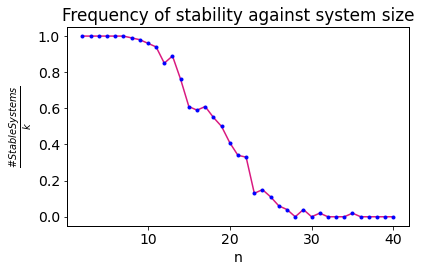

In [68]:
xdata = np.array(ns_test)
ydata = np.array(percents_stable)


# I forgot how to suppress matplotlib output automatically
plt.plot(xdata,ydata, color=(0.85,0.1,0.5));
plt.plot(xdata,ydata, 'b.');

plt.title('Frequency of stability against system size');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
# looks like logistic growth (decay, really)
plt.show();
# presence of exponentials makes enough sense given the type of math going on
# Fit with Negative binomial ( parameters )

The above data have a form similar to
$$ F(x) = a\frac{e^{r(x-d)}}{c+e^{r(x-d)}}, $$
with reals $r<0$ and $a,c,d>0$.

### Fitting the peculiar curve

In [36]:
from scipy.optimize import curve_fit

In [37]:
def logistic(x, a, r, c, d): # Model Guess 1: Logistic Decay
    y = a * (np.e**(r*(x-d)) / (c + np.e**(r*(x-d))))
    return y

# Model Guess 2: Negative Binomial (Failure Probability)

In [38]:
guess = [1, -0.1, 0.9, 20] # guess from playing with desmos sliders
parameters, covariance = curve_fit(logistic, xdata, ydata, p0 = guess) # least-squares default?
fit_a = parameters[0]
fit_r = parameters[1]
fit_c = parameters[2]
fit_d = parameters[3]
print(fit_a)
print(fit_r)
print(fit_c)
print(fit_d)

1.0275306602613261
-0.3091454442234268
0.8426471186664037
17.551979177607542


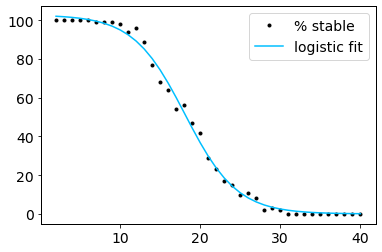

In [43]:
fit_logistic_y = logistic(xdata, fit_a, fit_r, fit_c, fit_d)
plt.plot(xdata, 100*ydata, 'k.', label='% stable');
plt.plot(xdata, 100*fit_logistic_y, 'deepskyblue', label='logistic fit');
plt.legend();


### Back to plotting eigvals

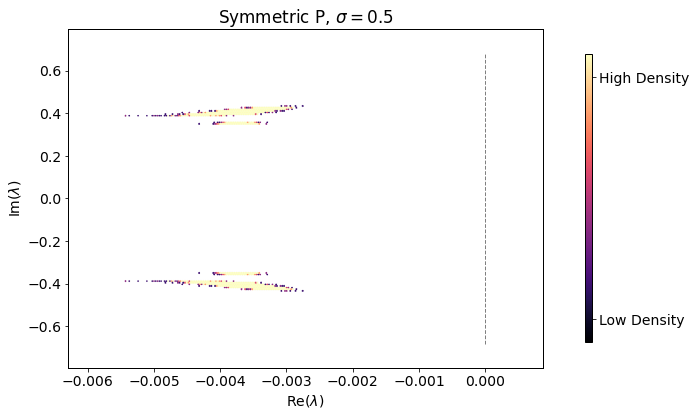

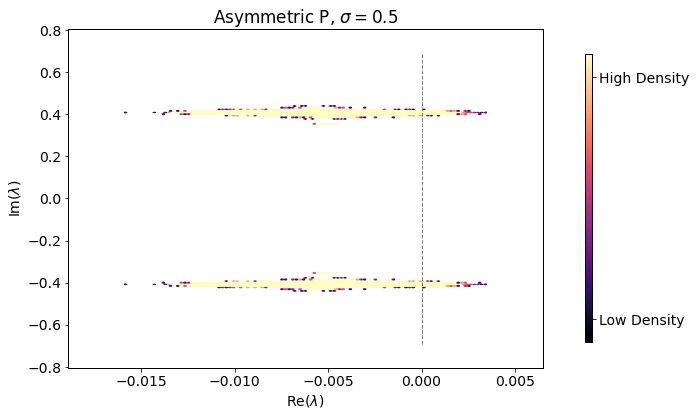

In [69]:
### Plot Eigenvalues of Many Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho)
    
# Loop the code below over a list of sigmas
    # Subplots with left column symmetric, right asymmetric
    # Make list, stability_probs. For each aEVs with different sig, append the
      # ratio of matrices that have any Re(eigval)>0 to k.

#sigs = [0.5,1,2,5,10]
sigs = [0.5]
# just have one pair (sEVs,aEVs) at a time for simplicity
    # generate sEVs, aEVs with current sigma
    # plot them
    # append to stability_freq using aEVs

n = 20      # number of species AND number of resrcs
k = 750     # number of systems to generate

sP = symPvec(sig=1, n=n, k=k)
aP = asymPvec(sig=1, n=n, k=k)

mu = (np.ones(n)*0.5).reshape(n,1)
rho = (np.ones(n)*0.5).reshape(n,1)


stability_freqs = []

for j, s in enumerate(sigs):

    sEVs = eigval_gen(sP, eps, mu, rho)
    aEVs = eigval_gen(aP, eps, mu, rho)
    
    for i, q in enumerate([sEVs, aEVs]): # i index, q current value
        x = q.real
        y = q.imag
        
        plt.rcParams["axes.edgecolor"] = "black" 
        plt.rcParams["axes.linewidth"] = 1 

        fig, ax = plt.subplots(figsize = (10, 6))

        cmap = mpl.cm.get_cmap("magma").copy()
        cmap.set_under(color = 'white') 

        plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

        font = {'size' : 14}
        plt.rc('font', **font)

        
        # plt.subplot(len(sigs),2,(j+i+1));
        plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

        plt.xlabel(r'Re($\lambda$)')
        plt.ylabel(r'Im($\lambda$)')


        plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
        ### originally, (10**(-8), 2.0)

        xmin, xmax = plt.xlim()
        nxm = (xmax - xmin) / 10 ### def'n some padding/margins
        plt.xlim((xmin - nxm, xmax + nxm))


        ### Adjusting Re axis tick marks
        if i==0: ### symmetric P
            loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Symmetric P, $\sigma={}$'.format(s))

        if i==1: ### asymmetric P
            loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Asymmetric P, $\sigma={}$'.format(s))
            
        cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
        locs = cb.get_ticks()
        tl = locs[-1] * 2 / 25
        cb.set_ticks([tl, locs[-1] - tl])
        cb.set_ticklabels(['Low Density', 'High Density'])


        ymin, ymax = plt.ylim()
        nym = (ymax - ymin) / 3
        plt.ylim((ymin - nym, ymax + nym))
        
        plt.tight_layout()
    
plt.show();

# Arnoldi Measures

In [ ]:
# "Resilience, reactivity and variability" (2016)

## Misc. Setup

In [70]:
def community_matr_gen(C,P,eps,mu,rho):
    '''
    Generate L, community matrix (Jacobian) of an O'Dwyer system described by given consumption matrix C, production matrix P, and mu, rho.
    '''
    
    n = P.shape[-1]
    k = P.shape[0]
    I = np.identity(n)
        
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)
    
    # Community Matrix Partitions
    CS = np.dot(C, S_star).T.reshape(k,n,1) # can use regular .T because first dimension is 1
    CR = np.dot(C, R_star).T.reshape(k,n,1)
    
    LA  = -CS * I
    LB = P - CR * I
    LC = eps * CS * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return L

In [72]:
def dom_eigvals(A): # for A with shape (k,2*n,2*n) ; returns entire eigval (complex, with sign)
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])
    
    k = A.shape[0]
        
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(abs(evs.real),-1))
    dom_ev = evs[np.arange(0,k), dom_ev_ind]
    
    return dom_ev
    

In [75]:
np.random.seed(999)
n = 2
k = 1000
mu = (np.ones(n)*0.5).reshape(n,1)
rho = (np.ones(n)*0.5).reshape(n,1)
eps = 0.25
C = np.identity(n)
P = asymPvec(sig = 1, n = n, k = k)

J = community_matr_gen(C,P,eps,mu,rho)
J.shape

(1000, 4, 4)

## Pre-Arnoldi sanity check

In [76]:
# Check that Jacobians are correct, because the Arnoldi measures down below are a little strange.

J[0,:,:]

# Equilibria
R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

R_star[0,:,:]
S_star[0,:,:]

#R_star
np.linalg.inv(C.T) * (1/eps) * (np.sum(P[0,:,:].T,-1) + mu)

#S_star
np.dot(np.linalg.inv(np.dot(np.diag(R_star[0,:,:].reshape(n)), C) - P[0,:,:]), rho)

#LA
np.diag(np.dot(-C,S_star[0,:,:]).reshape(2))

#LB
np.dot(-np.diag(R_star[0,:,:].reshape(2)), C) + P[0,:,:]

#LC
eps*np.diag(S_star[0,:,:].reshape(2))*C.T

S_star.shape

### The 4 Intrinsic Stability Measures

In [50]:
# 'A' will mean a (k,2*n,2*n) stack of community matrices (Jacobian evaluated at R_star,S_star)

#### Asymptotic Resilience

In [86]:
def asym_res(A):
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])
    
    evs = eigvals(A)
    k = A.shape[0]
    
    dom_ev_ind = (np.argmax(abs(eigvals(A).real),-1))
    dom_ev = evs[np.arange(0,k), dom_ev_ind]
    
    AR = -dom_ev.real
    
    return AR

In [90]:
# Test asymptotic resilience
AR = asym_res(J)
AR.shape
np.min(AR)
np.max(AR)

(1000,)

0.018750152139237263

0.12815113071956435

#### Deterministic Invariability

$$\mathcal{I}_D = \frac{1}{(\sup_{\omega}||i\omega - A)^{-1}||)}$$

In [91]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar # for Brent

In [85]:
def spectral_norm(A):
    dom_ev = dom_eigvals(np.dot(A.conj().T, A)) # from Arnoldi (2016) Appendix A
    
    return np.sqrt(abs(dom_ev.real))[0]

In [310]:
# find omega that minimizes -||inverse(i*om-A)||_{spectral}

# objective function
def determ_invar_OBJ(om): # _OBJ to imply that it is objective fn version (multiplied by -1)
    B = np.linalg.inv(complex(0,om) - A)  # call B the matrix whose spectral norm we aim to maximize
    
    spec_norm = spectral_norm(B)
    
    return -1 / spec_norm # negative because we are maximizing the non-negative version by minimizing this version

In [313]:
# Brent
guess = 1 # Brent does not take a guess?
# out2 = minimize_scalar(determ_invar_OBJ, method='brent', options={'disp': True}) # display convergence message, not available??? It's in the docs, tho
out2 = minimize_scalar(determ_invar_OBJ, method='brent')

In [314]:
out2.x

483443.6294856498

In [323]:
temp = []
for i in range(-1,2):
    temp.append(determ_invar(A,out2.x+i*99999))
temp # varies extremely slightly 

temp = np.array(temp)

np.diff(temp)

In [284]:
def determ_invar(A, om):
    # find omega=om that maximizes ||inverse(i*om-A)||_{spectral}, the frequency response
    # instead, find omega that minimizes -||inverse(i*om-A)||_{spectral}  
    
    B = np.linalg.inv(complex(0,om) - A)  # call B the matrix whose spectral norm we aim to maximize
    
    spec_norm = spectral_norm(B)
    
    return 1 / spec_norm
    

$$\mathcal{I}_S = \frac{1}{2} ||-\hat{A}^{-1}||^{-1}$$
$$ \hat{A} = A \otimes I + I \otimes A $$

#### Stochastic Invariability 

In [163]:
def stoch_invar(A): # Stochastic invariance
    # NOT vectorized bc Kronecker product (at the moment)
    I = np.identity(A.shape[-1])
    A_hat = np.kron(A,I) + np.kron(I,A)
    
    temp = -np.linalg.inv(A_hat)
    dom_real = np.max(abs(eigvals(temp).real))
    
    SI = 0.5 / dom_real
    
    return SI

In [164]:
SI = stoch_invar(J[0,:,:]) # this takes a while even for one community matrix
SI

0.037213522033455675

In [165]:
SI = []
for i in range(k):
    SI.append(stoch_invar(J[i,:,:]))

In [166]:
len(SI)

1000

In [167]:
SI = np.array(SI)

#### Initial Resilience

In [168]:
def init_res(A): # real part only, as implied but not defined in the paper. Property of A+A.T ???
    
    if A.ndim == 2:  # to account for passing a single community matrix A, shape (2*n,2*n)
        A = A.reshape(1,A.shape[0],A.shape[1])
    
    evs = eigvals(A + np.transpose(A,(0,2,1)))
    print('evs shape', evs.shape)
    k = A.shape[0]
    
    dom_ev_ind = np.argmax(abs(evs.real),1)
    dom_ev = evs[np.arange(0,k), dom_ev_ind].real # do this indexing to remember the sign of the dominant eigvals
    
    
    R0 = -0.5* dom_ev
    
    return R0

In [169]:
R0 = init_res(J)
R0.shape

evs shape (1000, 4)


(1000,)

In [ ]:
J_temp = J + np.transpose(J, (0,2,1))

In [ ]:
ev_temp = eigvals(J_temp)
ev_temp.shape

(5, 4)

In [ ]:
ev_temp

array([[  7.1009835,  -7.2482117,  -3.276566 ,   2.9363642],
       [ -9.2265337,  -7.3296911,   9.0891465,   7.1923546],
       [-11.1951709,  -9.0304882,  11.0854919,   8.9184519],
       [-14.6536044,  -9.6683624,  14.5563634,   9.5626086],
       [ -8.2099854,  -5.3755646,   5.1762009,   8.0709224]])

In [ ]:
np.max(abs(ev_temp).real, -1)

array([ 7.2482117,  9.2265337, 11.1951709, 14.6536044,  8.2099854])

In [ ]:
np.max(abs(ev_temp).real, -1)/2

array([3.6241058, 4.6132668, 5.5975855, 7.3268022, 4.1049927])

In [108]:
np.all(J[0,:,:] + J[0,:,:].T == (J + np.transpose(J,(0,2,1)))[0,:,:]) 

True

### R_0 vs. I_S plots

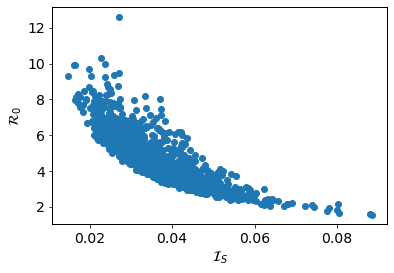

In [177]:
plt.scatter(SI, R0);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');

In [176]:
np.min(R0)

1.5655552147674954

In [122]:
# the thing where eigval(A+A.T) has no complex eigenvalues
X = np.random.rand(5,5) 
eigvals(X)
eigvals(X+X.T)

array([ 2.4295188+0.j       ,  0.9114107+0.j       ,
       -0.0527478+0.2730224j, -0.0527478-0.2730224j,
       -0.2871995+0.j       ])

array([ 4.9988901,  1.8959808, -0.9834953,  0.312489 , -0.3273957])

In [66]:
# miscellaneous test
np.all(np.linalg.inv(J)[67,:,:] == np.linalg.inv(J[67,:,:])) # wow, linalg.inv() just works on stacks

True

## "How ecosystems recover ..." (2018)

"We showed that in large, complex communities, due to the presence
of species with very different abundances, asymptotic resilience need not even be a good predictor 
of return rates at longer times."

"[...] asymptotic resilience should not be used as a proxy for the short-term recovery."

(pg. 8 "How ecosystems recover[...]")

In [63]:
### Arnoldi  "How ecosystems recover..."
n = 20 #repeated
import scipy as sp # for matrix exponential
from scipy.linalg import expm

In [64]:
# Return Rates
def R_avg(x, t, u):
    '''
    Average rate of return at current displacement 'x' after time 't' since initial perturbation 'u'
    '''
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [65]:
# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    '''
    Generate uniformly distributed unit-length  perturbation vector u.
    
    The direction is ostensibly the uniformly distributed value.
    '''
    v = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return v/np.linalg.norm(u,2) # does this provide uniformly distributed perturbation direction? They say so.

In [66]:
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

In [67]:
# Perturbation covariance matrix, Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equilibrium populations not being considered in perturbation distribution

In [68]:
# Choose an example system for testing Arnoldi measures
n_arn = 5
k_arn = 2
sig_arn = 1
eps = 0.25
c = 1
I = np.identity(n_arn)*c
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn)

In [69]:
R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
R_arn
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
S_arn

array([[[21.37291],
        [21.39909],
        [23.45758],
        [16.30727],
        [ 9.44006]],

       [[24.26847],
        [16.46217],
        [21.93636],
        [17.39659],
        [20.84921]]])

array([[[0.05537],
        [0.06235],
        [0.04888],
        [0.07907],
        [0.12859]],

       [[0.05021],
        [0.07179],
        [0.0616 ],
        [0.07525],
        [0.05683]]])

In [70]:
S_star_gen?

Signature: S_star_gen(C, P, R_star, rho)
Docstring: <no docstring>
File:      c:\users\riley\appdata\local\temp\ipykernel_11672\2300352256.py
Type:      function


In [71]:
LA  = -c * S_arn * I

LB = aP_arn - c * R_arn * I

LC = eps * c * S_arn * I
LD = np.zeros((k_arn,n_arn, n_arn))

L_top = np.concatenate((LA, LB), 2)
L_bot = np.concatenate((LC, LD), 2)
L_arn  = np.concatenate((L_top,L_bot), 1)

In [72]:
R_arn

array([[[21.37291],
        [21.39909],
        [23.45758],
        [16.30727],
        [ 9.44006]],

       [[24.26847],
        [16.46217],
        [21.93636],
        [17.39659],
        [20.84921]]])

In [73]:
RS_star = np.concatenate((R_arn,S_arn), 1) #(k,2*n,1), an example equilibrium
RS_star1, RS_star2 = RS_star

LAM = np.sum(np.square(RS_star)) #lambda, from Arnoldi Appendix E
Cov_prop = np.zeros((k_arn, 2*n_arn, 2*n_arn))
di_C = np.diag_indices(2*n_arn)
#Below LHS will be (k_arn, n_arn)
Cov_prop[:,di_C[0],di_C[1]] = (np.square(RS_star)/LAM).reshape(k_arn,2*n_arn) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

In [74]:
#Appendix E says the following:
def u_gen_prop(n, Nstar):
    ''' 
    Generate random perturbation 'u' such that u_i proportional to N*_i (population-proportional perturbations).
    '''
    v = np.random.normal(0,1,2*n).T
    D = np.diag(Nstar.reshape(2*n))
    w = np.dot(D,v) # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [75]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(expm(A*t)*Cov*expm(A.T*t)))

def R_avg_median(A,Cov,t): 
    '''Median of the average return rates'''
    return -(np.log(np.trace(expm(A*t)*Cov*expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [76]:
disp_med = disp_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
disp_med

R_avg_med = R_avg_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
R_avg_med

0.549650347953982

0.21760114661947677

In [77]:
### Return time 
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

# This will require a numerical solution

In [78]:
### Numerical solution to a simple system
# Careful of going back and re-running above blocks, reusing a lot of vars here
n_arn = 2
k_arn = 1
sig_arn = 1
eps = 0.25
c = 1
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn) * c

R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
RS_arn = np.concatenate((R_arn,S_arn),1)

In [79]:
R_star_gen?

Signature: R_star_gen(C, P, eps, mu)
Docstring:
..math::
    $\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$

Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).

No argument for number of sub-R_stars because that is inferred from 0th dimension of P argument.
File:      c:\users\riley\appdata\local\temp\ipykernel_11672\401698696.py
Type:      function


In [80]:
RS_arn

array([[[10.67441],
        [ 7.44102],
        [ 0.11091],
        [ 0.15213]]])

In [81]:
u_ex = u_gen_prop(n_arn,RS_arn.reshape(4))
np.linalg.norm(u_ex,2) #cool?

1.0

In [82]:
u_ex

array([ 0.74788, -0.66362,  0.00403, -0.01616])

In [83]:
# Just working with one example system, can get rid of "Stacking" for simplicity
aP_arn = aP_arn.reshape(n_arn,n_arn)
RS_arn = RS_arn.reshape(2*n_arn,1)

In [84]:
aP_arn
RS_arn

array([[1.2041 , 0.33129],
       [0.4645 , 0.52897]])

array([[10.67441],
       [ 7.44102],
       [ 0.11091],
       [ 0.15213]])

In [85]:
# Start with simple n=2 system for convenience starting out
def ResrcProd(N, t, C, P, mu, rho, eps): # why t? Unused

    R0, R1, S0, S1 = N # Ok, Resources are much more abundant

    dNdt = [rho[0]-R0*(C[0,0]*S0 + C[0,1]*S1) + P[0,0]*S0 + P[0,1]*S1,
            rho[1]-R1*(C[1,0]*S0 + C[1,1]*S1) + P[1,0]*S0 + P[1,1]*S1,
            eps*S0*( (C.T)[0,0]*R0 + (C.T)[0,1]*R1 ) - S0*((P.T)[0,0] + (P.T)[0,1]) - mu[0]*S0,
            eps*S1*( (C.T)[1,0]*R0 + (C.T)[1,1]*R1 ) - S1*((P.T)[1,0] + (P.T)[1,1]) - mu[1]*S1
           ]

    return dNdt

In [86]:
step = ResrcProd(list(RS_arn.reshape(2*n_arn)), 1, C_arn, aP_arn, list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps)

In [87]:
step
len(step)

[4.163336342344337e-17, -8.326672684688674e-17, 2.7755575615628914e-17, 0.0]

4

In [88]:
from scipy.integrate import odeint
import pandas as pd # once we start numerical solutions, might make sense to switch to dataframes

In [89]:
# Numerical solution for (2,2) system

t = np.linspace(0, 100, 1001) # time to simulate
RS_arn
u_2 = u_gen_prop(n_arn,RS_arn)
np.linalg.norm(u_2,2) # works
u_2 # proportions look good



array([[10.67441],
       [ 7.44102],
       [ 0.11091],
       [ 0.15213]])

1.0

array([-0.78655, -0.61727, -0.01486, -0.00945])

In [90]:
init_cond = list(u_2+RS_arn.reshape(2*n_arn))
u_2
RS_arn
init_cond

array([-0.78655, -0.61727, -0.01486, -0.00945])

array([[10.67441],
       [ 7.44102],
       [ 0.11091],
       [ 0.15213]])

[9.887859866983442,
 6.823744437636767,
 0.09605493773474132,
 0.14268205256086416]

In [91]:
sol = odeint(ResrcProd, init_cond, t, args=(C_arn, aP_arn.reshape(2,2), list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps))

In [92]:
sol.shape
sol = np.array(sol)

(1001, 4)

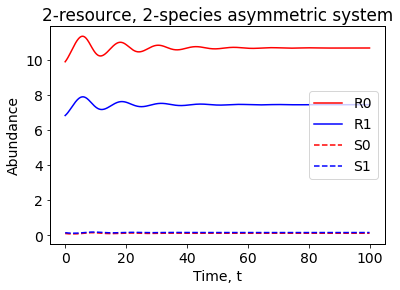

In [93]:
plt.plot(t, sol[:,0], 'r', label = 'R0');
plt.plot(t, sol[:,1],'b', label = 'R1');
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();

plt.title('2-resource, 2-species asymmetric system')
plt.xlabel('Time, t');
plt.ylabel('Abundance');

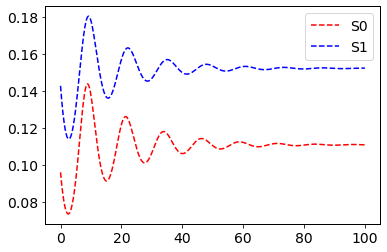

In [94]:
# giving the little guys a chance
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();


Text(0.5, 1.0, 'Phase Plane, S0 vs. S1')

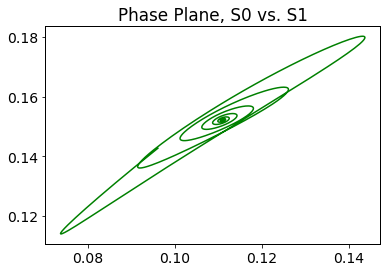

In [97]:
plt.plot(sol[:,2], sol[:,3], 'g');
plt.title('Phase Plane, S0 vs. S1');

In [ ]:
### NEXT STEPS FOR ARNOLDI TOOLS:
    ### Pick a threshold for the oscillations such that settles in ...

In [64]:
RS_arn
sol

array([[ 9.95217],
       [11.20718],
       [ 0.11446],
       [ 0.10963]])

array([[10.55582, 10.41076,  0.12575,  0.1442 ],
       [10.53949, 10.38956,  0.12764,  0.14132],
       [10.52122, 10.37158,  0.12949,  0.13843],
       ...,
       [ 9.95258, 11.20891,  0.11442,  0.10982],
       [ 9.95264, 11.20869,  0.11442,  0.10983],
       [ 9.95269, 11.20847,  0.11442,  0.10983]])

In [65]:
RS_arn

array([[ 9.95217],
       [11.20718],
       [ 0.11446],
       [ 0.10963]])

In [418]:
sol_xs = np.tile(RS_arn.reshape(4), (len(t), 1)) - sol # running difference between each state variable and its respective equilibrium
sol_xs

array([[ 6.80554e+00,  1.80939e+01,  1.45924e-01,  6.91107e-02],
       [ 6.69233e+00,  1.79805e+01,  5.99962e-02, -1.16109e-02],
       [ 6.56440e+00,  1.78498e+01, -1.30474e-02, -6.33053e-02],
       [ 6.42837e+00,  1.77091e+01, -7.56427e-02, -9.67523e-02],
       [ 6.28896e+00,  1.75628e+01, -1.29777e-01, -1.18714e-01],
       [ 6.14953e+00,  1.74138e+01, -1.77051e-01, -1.33430e-01],
       [ 6.01244e+00,  1.72640e+01, -2.18750e-01, -1.43564e-01],
       [ 5.87937e+00,  1.71143e+01, -2.55895e-01, -1.50790e-01],
       [ 5.75148e+00,  1.69656e+01, -2.89300e-01, -1.56166e-01],
       [ 5.62956e+00,  1.68184e+01, -3.19610e-01, -1.60361e-01],
       [ 5.51410e+00,  1.66729e+01, -3.47336e-01, -1.63800e-01],
       [ 5.40540e+00,  1.65294e+01, -3.72885e-01, -1.66753e-01],
       [ 5.30360e+00,  1.63881e+01, -3.96577e-01, -1.69393e-01],
       [ 5.20871e+00,  1.62489e+01, -4.18664e-01, -1.71830e-01],
       [ 5.12067e+00,  1.61121e+01, -4.39348e-01, -1.74134e-01],
       [ 5.03933e+00,  1.

NameError: name 'disps' is not defined

In [402]:
# plt.plot(t, sol[:,0], 'r', sol[:,1],'b', sol[:,2],'r--', sol[:,3],'b--');

In [ ]:
######################################
######## Back to O'Dwyer Plots #######
######################################

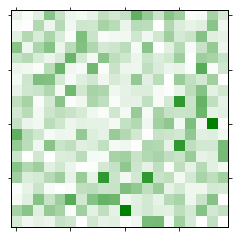

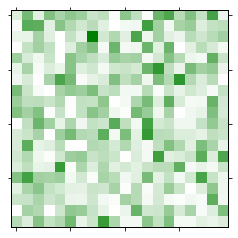

In [132]:
### Plot Grid Representing Production Matrix P ###

for i, M in enumerate([sP, aP]):
    
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'green'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                    cmap=c_map)

    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis = 'both',          
                    which = 'both',      
                    bottom = 'off',      
                    top = 'off',         
                    labelbottom = 'off',
                    left = 'off',
                    right = 'off')

    ax.grid(False)
plt.show();

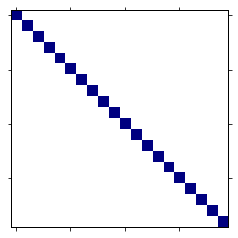

In [133]:
### Plot grid representing consumption C ###

C = c*I

for M in [C]:
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'navy'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                        cmap=c_map)


    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis='both',          
                    which='both',      
                    bottom='off',      
                    top='off',         
                    labelbottom='off',
                    left='off',
                    right='off')

    ax.grid(False)


In [ ]:
### Diversity Indices

#def alpha_???(N): # population vector N
    